1. Load and prepare the available data as needed. (5%)
2. Transform the input text using a suitable representation for each model. (10%)
3. Implement three Naïve Bayes models for sentiment analysis: (a) The first will be trained on the
Rotten Tomatoes Movie Reviews (RTMR) dataset and tested separately on the RTMR and the
Sentiment140 (S140) datasets. (b) The second will be trained on S140 and tested separately on
RTMR and S140. (c) The third will be trained on the combination of RTMR and S140 and tested
separately on RTMR and S140. (12%)
4. Implement a Convolutional Neural Network (CNN) model for sentiment analysis. Train your model
on the RTMR dataset and test it separately on the RTMR and S140 datasets. (11.5%)
5. Implement a Recurrent Neural Network (RNN) or a Long Short Term Memory (LSTM) model for
sentiment analysis. Train your model on the RTMR dataset and test it separately on the RTMR and
S140 datasets. (11.5%)
6. Compute the confusion matrix, accuracy, F1-score, precision and recall for each model and
training/test configuration. (10%)
7. Store the five trained models in files and implement a function “predict_post(text, model)” that
given a text string (“text”) and model filename (“model”), it will load the pre-trained model, and
predict the sentiment class of the input text. (10%)

1. Load and prepare the available data as needed. (5%)

In [1]:
import pandas as pd   #the reason to first strip content that has only one word or character is because we want to use all of the testing set
#so we need to know how many valid data there are in the test set in order to know how many data we should use for the training set

rtmr_train=pd.read_csv('rtmr_train.tsv',sep='\t')
rtmr_train['Sentiment'] = rtmr_train['Sentiment'].replace([1],0) #categorise sentiment=1 as sentiment=0, and sentiment=3 as sentiment=4
rtmr_train['Sentiment'] = rtmr_train['Sentiment'].replace([3],4)
rtmr_train_phrases=rtmr_train['Phrase'].tolist() #convert column 'Phrase' in the training set to a list and store it as variable Phrase_train
rtmr_train_sen=rtmr_train['Sentiment'].tolist() #convert column 'Sentiment' in the training set to a list and store it as variable Sentiment_train

rtmr_test=pd.read_csv('rtmr_test.tsv', sep='\t')
rtmr_test['Sentiment'] = rtmr_test['Sentiment'].replace([1],0)
rtmr_test['Sentiment'] = rtmr_test['Sentiment'].replace([3],4)
rtmr_test_phrases=rtmr_test['Phrase'].tolist()   #convert column 'Phrase' in the test set to a list and store it as variable Phrase_test
rtmr_test_sen=rtmr_test['Sentiment'].tolist()  #convert column 'Sentiment' in the test set to a list and store it as variable Sentiment_test

s140_train=pd.read_csv('s140_train.csv',names=['Sentiment','Number','Time', 'Theme','ID','Tweets'])#read csv file and give each column a name
s140_train_tweets=s140_train['Tweets'].tolist() #add column name 'tweets' to the dataframe
s140_train_sen=s140_train['Sentiment'].tolist()

s140_test=pd.read_csv('s140_test.csv', names=['Sentiment','Number','Time', 'Theme','ID','Tweets'])
s140_test_tweets=s140_test['Tweets'].tolist() 
s140_test_sen=s140_test['Sentiment'].tolist()

print('Number of phrases and sentiments in RTMR training file: {}'.format(len(rtmr_train_phrases)))
print('Number of phrases and sentiments in RTMR test file: {}'.format(len(rtmr_test_phrases)))
print('Number of phrases and sentiments in S140 training file: {}'.format(len(s140_train_tweets)))
print('Number of phrases and sentiments in S140 test file: {}'.format(len(s140_test_tweets)))

Number of phrases and sentiments in RTMR training file: 148256
Number of phrases and sentiments in RTMR test file: 7803
Number of phrases and sentiments in S140 training file: 1600000
Number of phrases and sentiments in S140 test file: 498


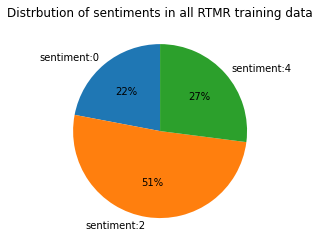

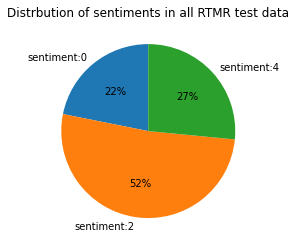

In [2]:
import matplotlib.pyplot as plt
rtmr_distribution=[(rtmr_train_sen.count(0)/len(rtmr_train_sen))*100,(rtmr_train_sen.count(2)/len(rtmr_train_sen))*100,
                      (rtmr_train_sen.count(4)/len(rtmr_train_sen))*100]

rtmr_plot=plt.pie(rtmr_distribution,labels=['sentiment:0','sentiment:2','sentiment:4'],startangle = 90,autopct = '%1.0f%%');
plt.title('Distrbution of sentiments in RTMR training data')
plt.show()
rtmr_distribution_test=[(rtmr_test_sen.count(0)/len(rtmr_test_sen))*100,(rtmr_test_sen.count(2)/len(rtmr_test_sen))*100,
                      (rtmr_test_sen.count(4)/len(rtmr_test_sen))*100]

rtmr_plot=plt.pie(rtmr_distribution_test,labels=['sentiment:0','sentiment:2','sentiment:4'],startangle = 90,autopct = '%1.0f%%');
plt.title('Distrbution of sentiments in RTMR test data')
plt.show()

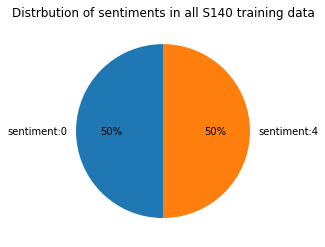

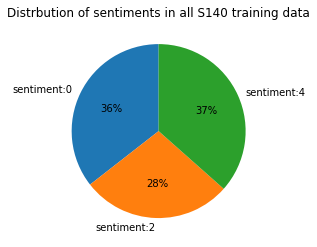

In [3]:
s140_distribution=[(s140_train_sen.count(0)/len(s140_train_sen))*100,(s140_train_sen.count(4)/len(s140_train_sen))*100]
s140_plot=plt.pie(s140_distribution,labels=['sentiment:0','sentiment:4'],startangle = 90,autopct = '%1.0f%%')
plt.title('Distrbution of sentiments in S140 training data')
plt.show() 

s140_distribution_test=[(s140_test_sen.count(0)/len(s140_test_sen))*100,(s140_test_sen.count(2)/len(s140_test_sen))*100,
                        (s140_test_sen.count(4)/len(s140_test_sen))*100]
s140_plot=plt.pie(s140_distribution_test,labels=['sentiment:0','sentiment:2','sentiment:4'],startangle = 90,autopct = '%1.0f%%')
plt.title('Distrbution of sentiments in S140 training data')
plt.show() 

2.Transform the input text using a suitable representation for each model. (10%)

2.1.Checking invalid training phrases and tweets

In [6]:
#The first step of preprocessing is to make sure that all reviews and tweets in the training set are longer than one word/symbol

rtmr_phrase_tr=[]
rtmr_sentiment_tr=[]
for x in range(len(rtmr_train_phrases)):   #iterating through the list of phrases in the training set
    if len(rtmr_train_phrases[x].lower())>1:  #if the length of the phrase is longer than one (this step disgards valid data)
        phrase=rtmr_train_phrases[x].lower()  #append the phrase to a new list in lower case
        sentiment=rtmr_train_sen[x]    #get the corresponding sentiment
        rtmr_phrase_tr.append(phrase)
        rtmr_sentiment_tr.append(sentiment)

print('{} invalid phrases in the RTMR training data are removed'.format(len(rtmr_train_phrases)-len(rtmr_phrase_tr)))
print('Total RTMR training phrases: {} '.format(len(rtmr_phrase_tr)),'Total RTMR training sentiments: {} '.format(len(rtmr_sentiment_tr)))

42 invalid phrases in the RTMR training data are removed
Total RTMR training phrases: 148214  Total RTMR training sentiments: 148214 


In [7]:
#check for invalid tweets in the S140 training data
time=0
for x in range(len(s140_train_tweets)):
    if len(s140_train_tweets[x].lower())>1:
        time+=1
        if time==len(s140_train_tweets):
            print('There is no invalid tweet in the S140 training set')
print('Total S140 training tweets: {} '.format(len(s140_train_tweets)),'Total S140 training sentiments: {} '.format(len(s140_train_sen)))

There is no invalid tweet in the S140 training set
Total S140 training tweets: 1600000  Total S140 training sentiments: 1600000 


2.2 Specifying training set size according to test set (80% training data / 20% test data)

In [8]:
# we use the first 31212 rows as RTMR training data as 7803/0.2*0.8=31212
# test set+training set= 7803+31212=39015

rtmr_phrase_tr=rtmr_phrase_tr[0:31212]
rtmr_sentiment_tr=rtmr_sentiment_tr[0:31212]
print('RTMR training set size: {} '.format(len(rtmr_phrase_tr)))
print('RTMR test set size: {} '.format(len(rtmr_test_phrases)))

RTMR training set size: 31212 
RTMR test set size: 7803 


In [9]:
# because there are no invalid tweets in the list, we use the first 1992 rows as training data as 498/0.2*0.8=1992
# test set+training set= 498+1992=2490

#to make the training set more representative of the whole set, 50% of the data needs have sentiment=4, 
#the other half sentiment=0, and we know the first 800000 is sentiment=0
s140_tweets_tr=s140_train_tweets[0:996]+s140_train_tweets[800001:800001+996] 
s140_sentiment_tr=s140_train_sen[0:996]+s140_train_sen[800001:800001+996]
#print('There are {} tweets in the S140 training set'.format(len(tweets_tr)))
#print('There are {} number of sentiments in the S140 training set'.format(len(tweet_sentiment_tr)))

#print(s140_sentiment_tr.count(0))  check that there are 50% sentiment 4 and 50% sentiment 0
#print(s140_sentiment_tr.count(4))

print('S140 training set size: {} '.format(len(s140_tweets_tr)),'80%')
print('S140 test set size: {} '.format(len(s140_test_tweets)),'20%')

S140 training set size: 1992  80%
S140 test set size: 498  20%


In [10]:
#list the names of training and test data
print('training set name            test set name')
print('---------------------------------------------')
print('content: rtmr_phrase_tr    |rtmr_test_phrases ')
print('sentiment:rtmr_sentiment_tr|rtmr_test_sen')
print('---------------------------------------------')
print('content: s140_tweets_tr    | s140_test_tweets')
print('sentiment:s140_sentiment_tr| s140_test_sen')

training set name            test set name
---------------------------------------------
content: rtmr_phrase_tr    |rtmr_test_phrases 
sentiment:rtmr_sentiment_tr|rtmr_test_sen
---------------------------------------------
content: s140_tweets_tr    | s140_test_tweets
sentiment:s140_sentiment_tr| s140_test_sen


2.3 Tokenisation

In [11]:
from nltk import word_tokenize   #tokenissing phrases and tweets and getting rid of puctuations as well as stopwords
import re
from string import punctuation
from nltk.corpus import stopwords

punctuation_list = list(punctuation)
stopwords=stopwords.words('english')
stopwords.remove('no')  #because no and not are very important indicator of emotions so we keep them here
stopwords.remove('not')
stopwords.remove('nor')
stopwords.append("'s")
stopwords.append('--')
stopwords.append('_')
stopwords.append('..')
stopwords.append('``')
stopwords.append('...')
stopwords.append("'ll")
stopwords.append("'ve")
stopwords.append("'d")
stopwords.append("i'm")

rtmr_phrase_tr_tokenised=[]
rtmr_phrase_test_tokenised=[]

#tokenising and preprocessing RTMR training data
for x in range(len(rtmr_phrase_tr)):
        tokens=word_tokenize(rtmr_phrase_tr[x])
        rtmr_phrase_tr_tokenised.append(tokens)

#print(phrase_tr_tokenised[1:10])
#print(phrase_tr[1:10])

rtmr_phrase_tr_preprocessed = rtmr_phrase_tr_tokenised  #this preprocessing method imitates workshop 7
for i in range(len(rtmr_phrase_tr_tokenised)):
    new_tokens=[]
    for word in rtmr_phrase_tr_tokenised[i]:
        word=word.replace('-','')
        if word not in stopwords and word not in punctuation_list:
            new_tokens.append(word)
    rtmr_phrase_tr_preprocessed[i]=new_tokens

rtmr_dataset_train=[]
for i in range(len(rtmr_phrase_tr_preprocessed)):
    text=' '.join(rtmr_phrase_tr_preprocessed[i])
    rtmr_dataset_train.append(text)
print(rtmr_dataset_train[0:10])

#tokenising and preprocessing RTMR testing data
for x in range(len(rtmr_test_phrases )):
        tokens=word_tokenize(rtmr_test_phrases [x].lower())
        rtmr_phrase_test_tokenised.append(tokens)
        
rtmr_phrase_test_preprocessed = rtmr_phrase_test_tokenised 

for i in range(len(rtmr_phrase_test_tokenised)):
    new_tokens=[]
    for word in rtmr_phrase_test_tokenised[i]:
        word=word.replace('-','')
        word=word.replace("n't", 'not')
        if word not in stopwords and word not in punctuation_list:
            new_tokens.append(word)
    rtmr_phrase_test_preprocessed[i]=new_tokens

rtmr_dataset_test=[]
for i in range(len(rtmr_phrase_test_preprocessed)):
    text=' '.join(rtmr_phrase_test_preprocessed[i])
    rtmr_dataset_test.append(text)
print(rtmr_dataset_test[0:10])

['seen murphy', 'exoticism', 'script', 'expected', 'standard policeoriented drama not de niro participation would likely wound tnt original', 'title performance kieran culkin', 'lack idol energy passion detail', 'unfunny lacking sense commitment affection characters reginald hudlin comedy relies toilet humor ethnic slurs', 'situation', 'achievement']
['despite modest aspirations occasional charms not dismissed', 'depiction', 'punched inconsistent meandering sometimes dry plot', 'robert deniro showtime', 'young artist', 'visual rorschach test', 'no matter firmly director john stainton tongue cheek', 'robert harmon lessismore approach delivers real bumpin  thenight chills ', 'remarkable film', 'watch']


In [12]:
s140_tweets_tr_tokenised=[]
s140_tweets_test_tokenised=[]

#tokenising and preprocessing RTMR training data  
tweets_training=s140_tweets_tr

for x in range(len(s140_tweets_tr)):
    regex_check = re.match('[@a-zA-Z]+',s140_tweets_tr[x])
    if regex_check!=None:
        tweets_training[x]=s140_tweets_tr[x].replace(regex_check.group(),'')
        tokens=word_tokenize(tweets_training[x].lower())
        s140_tweets_tr_tokenised.append(tokens)
    else:
        tokens=word_tokenize(tweets_training[x].lower())
        s140_tweets_tr_tokenised.append(tokens)
        
s140_tweets_tr_preprocessed = s140_tweets_tr_tokenised 
for i in range(len(s140_tweets_tr_tokenised)):
    new_tokens=[]
    for word in s140_tweets_tr_tokenised[i]:
        word=word.replace('-','')
        word=word.replace("n't", 'not')
        if word not in stopwords and word not in punctuation_list:
            new_tokens.append(word)
    s140_tweets_tr_preprocessed[i]=new_tokens

s140_dataset_train=[]
for i in range(len(s140_tweets_tr_preprocessed)):
    text=' '.join(s140_tweets_tr_preprocessed[i])
    s140_dataset_train.append(text)

print(s140_dataset_train[0:10])

tweets_testing=s140_test_tweets

for x in range(len(s140_test_tweets)):
    regex_check = re.match('[@a-zA-Z]+',s140_test_tweets[x])
    if regex_check!=None:
        tweets_testing[x]=s140_test_tweets[x].replace(regex_check.group(),'')
        tokens=word_tokenize(tweets_testing[x].lower())
        s140_tweets_test_tokenised.append(tokens)
    else:
        tokens=word_tokenize(tweets_training[x].lower())
        s140_tweets_test_tokenised.append(tokens)
        
s140_tweets_test_preprocessed = s140_tweets_test_tokenised 
for i in range(len(s140_tweets_test_tokenised)):
    new_tokens=[]
    for word in s140_tweets_test_tokenised[i]:
        word=word.replace('-','')
        word=word.replace("n't", 'not')
        if word not in stopwords and word not in punctuation_list:
            new_tokens.append(word)
    s140_tweets_test_preprocessed[i]=new_tokens

s140_dataset_test=[]
for i in range(len(s140_tweets_test_preprocessed)):
    text=' '.join(s140_tweets_test_preprocessed[i])
    s140_dataset_test.append(text)

print(s140_dataset_test[0:10])

['http //twitpic.com/2y1zl  awww bummer shoulda got david carr third day', 'upset ca not update h facebook texting might cry result school today also blah', 'dived many times ball managed save 50 rest go bounds', 'whole body feels itchy like fire', "no not behaving 'm mad ca not see", 'not whole crew', 'hug', "hey long time no see yes rains bit bit lol 'm fine thanks", '_k nope not', 'que muera']
['loooooooovvvvvveee kindle2 not dx cool 2 fantastic right', 'kindle2 love lee childs good read', 'first assesment kindle2 fucking rocks', 'love kindle2 mine months never looked back new big one huge no need remorse', 'fair enough kindle2 think perfect', "no big 'm quite happy kindle2", 'economy hate aig non loan given asses', 'new best friend', 'twitter', 'not love obama makes jokes']


3.Implement three Naïve Bayes models for sentiment analysis: (a) The first will be trained on the Rotten Tomatoes Movie Reviews (RTMR) dataset and tested separately on the RTMR and the Sentiment140 (S140) datasets. (b) The second will be trained on S140 and tested separately on RTMR and S140. (c) The third will be trained on the combination of RTMR and S140 and tested separately on RTMR and S140. (12%) 

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline

# Build the Naive Bayes model by setting a pipeline where the input is first converted
# to TF-IDF vectors and then a Multinomial Naive Bayes is used
model = make_pipeline(TfidfVectorizer(), MultinomialNB())

#(a) The first will be trained on the RTMR dataset and tested separately on the RTMR and the Sentiment140 (S140) datasets.
model_a=model.fit(rtmr_dataset_train, rtmr_sentiment_tr) # Train the model on the training data
predicted_categories = model_a.predict(rtmr_dataset_test) # Predict the categories of the test data
print('Model A: trained on RTMR and tested on RTMR')
print("Predicted:",predicted_categories.tolist()[0:10]) # Print the first 10 predictions
print("Expected: ",rtmr_test_sen[0:10]) # Print the first 10 ground truth values

predicted_categories_tweets = model_a.predict(s140_dataset_test)
print('\nModel A: trained on RTMR and tested on S140')
print("Predicted:",predicted_categories_tweets.tolist()[0:10]) # Print the first 10 predictions
print("Expected: ",s140_test_sen[0:10]) # Print the first 10 ground truth values

Model A: trained on RTMR and tested on RTMR
Predicted: [4, 2, 0, 2, 2, 2, 2, 4, 4, 2]
Expected:  [4, 2, 0, 2, 2, 2, 2, 4, 4, 2]

Model A: trained on RTMR and tested on S140
Predicted: [4, 2, 2, 2, 2, 2, 2, 4, 2, 2]
Expected:  [4, 4, 4, 4, 4, 4, 0, 4, 4, 4]


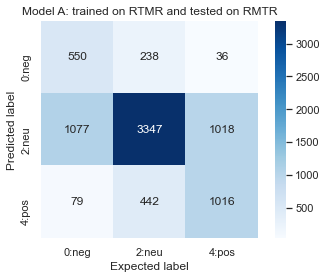

Accuracy: 0.630
F1-score: 0.568
Precision: 0.648
Recall: 0.548
              precision    recall  f1-score   support

           0       0.67      0.32      0.43      1706
           2       0.62      0.83      0.71      4027
           4       0.66      0.49      0.56      2070

    accuracy                           0.63      7803
   macro avg       0.65      0.55      0.57      7803
weighted avg       0.64      0.63      0.61      7803



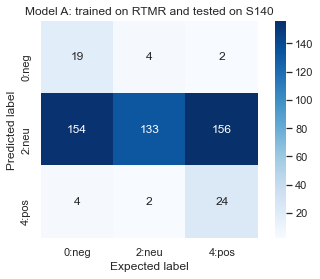

Accuracy: 0.353
F1-score: 0.291
Precision: 0.620
Recall: 0.399
              precision    recall  f1-score   support

           0       0.76      0.11      0.19       177
           2       0.30      0.96      0.46       139
           4       0.80      0.13      0.23       182

    accuracy                           0.35       498
   macro avg       0.62      0.40      0.29       498
weighted avg       0.65      0.35      0.28       498



In [15]:
#(a) The first will be trained on the Rotten Tomatoes Movie Reviews (RTMR) dataset 
#and tested separately on the RTMR and the Sentiment140 (S140) datasets
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, f1_score, precision_score, recall_score,classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() # use seaborn plotting style
# Plot the confusion matrix
predicted_categories = model_a.predict(rtmr_dataset_test)
mat=confusion_matrix(rtmr_test_sen,predicted_categories)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",cmap='Blues',xticklabels=['0:neg','2:neu','4:pos'], yticklabels=['0:neg','2:neu','4:pos'])
plt.xlabel("Expected label")
plt.ylabel("Predicted label")
plt.title('Model A: trained on RTMR and tested on RMTR')
plt.show()

print('Accuracy: {:.3f}'.format(accuracy_score(rtmr_test_sen,predicted_categories)))
print('F1-score: {:.3f}'.format(f1_score(rtmr_test_sen,predicted_categories, average='macro')))
print('Precision: {:.3f}'.format(precision_score(rtmr_test_sen,predicted_categories, average='macro')))
print('Recall: {:.3f}'.format(recall_score(rtmr_test_sen,predicted_categories, average='macro')))
print(classification_report(rtmr_test_sen,predicted_categories))

import warnings
warnings.filterwarnings("ignore")
mat = confusion_matrix(s140_test_sen,predicted_categories_tweets)
sns.heatmap(mat.T, square = True,annot=True, fmt = "d",cmap='Blues',xticklabels=['0:neg','2:neu','4:pos'], yticklabels=['0:neg','2:neu','4:pos'])
plt.xlabel("Expected label")
plt.ylabel("Predicted label")
plt.title('Model A: trained on RTMR and tested on S140')
plt.show()

print('Accuracy: {:.3f}'.format(accuracy_score(s140_test_sen,predicted_categories_tweets)))
print('F1-score: {:.3f}'.format(f1_score(s140_test_sen,predicted_categories_tweets, average='macro')))
print('Precision: {:.3f}'.format(precision_score(s140_test_sen,predicted_categories_tweets, average='macro')))
print('Recall: {:.3f}'.format(recall_score(s140_test_sen,predicted_categories_tweets, average='macro')))
print(classification_report(s140_test_sen,predicted_categories_tweets))

In [16]:
#(b) The second will be trained on S140 and tested separately on RTMR and S140
model_b=model.fit(s140_dataset_train,s140_sentiment_tr) # Train the model on the training data
predicted_categories_b = model_b.predict(rtmr_dataset_test) # Predict the categories of the test data

print('Model B: trained on S140 and tested on RTMR')
print("Predicted:",predicted_categories_b.tolist()[0:10]) # Print the first 10 predictions
print("Expected: ",rtmr_test_sen[0:10]) # Print the first 10 ground truth values

predicted_categories_b_2 = model_b.predict(s140_dataset_test) # Predict the categories of the test data

print('\nModel B: trained on S140 and tested on S140')
print("Predicted:",predicted_categories_b_2.tolist()[0:10]) # Print the first 10 predictions
print("Expected: ",s140_test_sen[0:10]) # Print the first 10 ground truth values

Model B: trained on S140 and tested on RTMR
Predicted: [0, 0, 4, 0, 0, 0, 0, 4, 0, 4]
Expected:  [4, 2, 0, 2, 2, 2, 2, 4, 4, 2]

Model B: trained on S140 and tested on S140
Predicted: [4, 4, 4, 4, 0, 4, 0, 4, 4, 4]
Expected:  [4, 4, 4, 4, 4, 4, 0, 4, 4, 4]


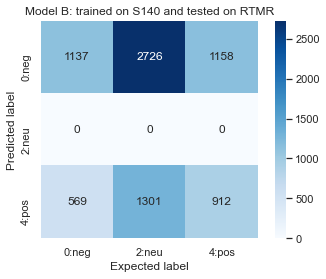

Accuracy: 0.263
F1-score: 0.238
Precision: 0.185
Recall: 0.369
              precision    recall  f1-score   support

           0       0.23      0.67      0.34      1706
           2       0.00      0.00      0.00      4027
           4       0.33      0.44      0.38      2070

    accuracy                           0.26      7803
   macro avg       0.18      0.37      0.24      7803
weighted avg       0.14      0.26      0.17      7803



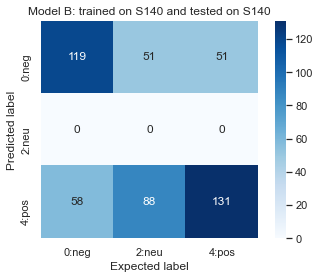

Accuracy: 0.502
F1-score: 0.390
Precision: 0.337
Recall: 0.464
              precision    recall  f1-score   support

           0       0.54      0.67      0.60       177
           2       0.00      0.00      0.00       139
           4       0.47      0.72      0.57       182

    accuracy                           0.50       498
   macro avg       0.34      0.46      0.39       498
weighted avg       0.36      0.50      0.42       498



In [17]:
#(b) The second will be trained on S140 and tested separately on RTMR and S140. 
mat = confusion_matrix(rtmr_test_sen,predicted_categories_b)
sns.heatmap(mat.T, square = True,annot=True, fmt = "d",cmap='Blues',xticklabels=['0:neg','2:neu','4:pos'], yticklabels=['0:neg','2:neu','4:pos'])
plt.xlabel("Expected label")
plt.ylabel("Predicted label")
plt.title('Model B: trained on S140 and tested on RTMR')
plt.show()
print('Accuracy: {:.3f}'.format(accuracy_score(rtmr_test_sen,predicted_categories_b)))
print('F1-score: {:.3f}'.format(f1_score(rtmr_test_sen,predicted_categories_b, average='macro')))
print('Precision: {:.3f}'.format(precision_score(rtmr_test_sen,predicted_categories_b, average='macro')))
print('Recall: {:.3f}'.format(recall_score(rtmr_test_sen,predicted_categories_b, average='macro')))
print(classification_report(rtmr_test_sen,predicted_categories_b.tolist()))

mat= confusion_matrix(s140_test_sen,predicted_categories_b_2)
sns.heatmap(mat.T, square = True,annot=True, fmt = "d",cmap='Blues',xticklabels=['0:neg','2:neu','4:pos'], yticklabels=['0:neg','2:neu','4:pos'])
plt.xlabel("Expected label")
plt.ylabel("Predicted label")
plt.title('Model B: trained on S140 and tested on S140')
plt.show()
print('Accuracy: {:.3f}'.format(accuracy_score(s140_test_sen,predicted_categories_b_2)))
print('F1-score: {:.3f}'.format(f1_score(s140_test_sen,predicted_categories_b_2, average='macro')))
print('Precision: {:.3f}'.format(precision_score(s140_test_sen,predicted_categories_b_2, average='macro')))
print('Recall: {:.3f}'.format(recall_score(s140_test_sen,predicted_categories_b_2, average='macro')))
print(classification_report(s140_test_sen,predicted_categories_b_2))

In [18]:
#(c) The third will be trained on the combination of RTMR and S140 and tested separately on RTMR and S140
model_c=model.fit(rtmr_dataset_train+s140_dataset_train,rtmr_sentiment_tr+s140_sentiment_tr) # Train the model on the training data
predicted_categories_c = model_c.predict(rtmr_dataset_test) # Predict the categories of the test data

print('Model C: trained on RTMR+S140 and tested on RTMR')
print("Predicted:",predicted_categories_c.tolist()[0:10]) # Print the first 10 predictions
print("Expected: ",rtmr_test_sen[0:10]) # Print the first 10 ground truth values

predicted_categories_c_2= model_c.predict(s140_dataset_test) # Predict the categories of the test data
print('\nModel C: trained on RTMR+S140 and tested on S140')
print("Predicted:",predicted_categories_c_2.tolist()[0:10]) # Print the first 10 predictions
print("Expected: ",s140_test_sen[0:10]) # Print the first 10 ground truth values

Model C: trained on RTMR+S140 and tested on RTMR
Predicted: [4, 2, 0, 2, 2, 2, 2, 4, 4, 2]
Expected:  [4, 2, 0, 2, 2, 2, 2, 4, 4, 2]

Model C: trained on RTMR+S140 and tested on S140
Predicted: [4, 4, 4, 2, 4, 4, 2, 4, 4, 4]
Expected:  [4, 4, 4, 4, 4, 4, 0, 4, 4, 4]


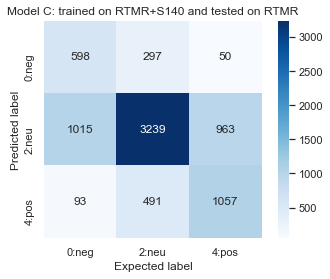

Accuracy: 0.627
F1-score: 0.574
Precision: 0.633
Recall: 0.555
              precision    recall  f1-score   support

           0       0.63      0.35      0.45      1706
           2       0.62      0.80      0.70      4027
           4       0.64      0.51      0.57      2070

    accuracy                           0.63      7803
   macro avg       0.63      0.56      0.57      7803
weighted avg       0.63      0.63      0.61      7803



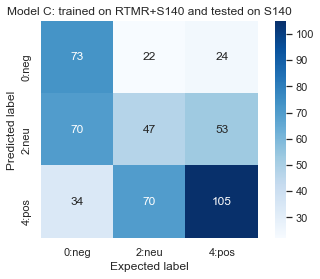

Accuracy: 0.452
F1-score: 0.445
Precision: 0.464
Recall: 0.442
              precision    recall  f1-score   support

           0       0.61      0.41      0.49       177
           2       0.28      0.34      0.30       139
           4       0.50      0.58      0.54       182

    accuracy                           0.45       498
   macro avg       0.46      0.44      0.44       498
weighted avg       0.48      0.45      0.46       498



In [19]:
#(c) The third will be trained on the combination of RTMR and S140 and tested separately on RTMR and S140
mat= confusion_matrix(rtmr_test_sen,predicted_categories_c)
sns.heatmap(mat.T, square = True,annot=True, fmt = "d",cmap='Blues',xticklabels=['0:neg','2:neu','4:pos'], yticklabels=['0:neg','2:neu','4:pos'])
plt.xlabel("Expected label")
plt.ylabel("Predicted label")
plt.title('Model C: trained on RTMR+S140 and tested on RTMR')
plt.show()
print('Accuracy: {:.3f}'.format(accuracy_score(rtmr_test_sen,predicted_categories_c)))
print('F1-score: {:.3f}'.format(f1_score(rtmr_test_sen,predicted_categories_c, average='macro')))
print('Precision: {:.3f}'.format(precision_score(rtmr_test_sen,predicted_categories_c, average='macro')))
print('Recall: {:.3f}'.format(recall_score(rtmr_test_sen,predicted_categories_c, average='macro')))
print(classification_report(rtmr_test_sen,predicted_categories_c))

mat_2 = confusion_matrix(s140_test_sen,predicted_categories_c_2)
sns.heatmap(mat_2.T, square = True,annot=True, fmt = "d",cmap='Blues',xticklabels=['0:neg','2:neu','4:pos'], yticklabels=['0:neg','2:neu','4:pos'])
plt.xlabel("Expected label")
plt.ylabel("Predicted label")
plt.title('Model C: trained on RTMR+S140 and tested on S140')
plt.show()
print('Accuracy: {:.3f}'.format(accuracy_score(s140_test_sen,predicted_categories_c_2)))
print('F1-score: {:.3f}'.format(f1_score(s140_test_sen,predicted_categories_c_2, average='macro')))
print('Precision: {:.3f}'.format(precision_score(s140_test_sen,predicted_categories_c_2, average='macro')))
print('Recall: {:.3f}'.format(recall_score(s140_test_sen,predicted_categories_c_2, average='macro')))
print(classification_report(s140_test_sen,predicted_categories_c_2))

4. Implement a Convolutional Neural Network (CNN) model for sentiment analysis. Train your model on the RTMR dataset and test it separately on the RTMR and S140 datasets. (11.5%)

In [69]:
rtmr_dataset_train=[s+' unknown'for s in rtmr_dataset_train]
rtmr_dataset_test=[s+' unknown'for s in rtmr_dataset_test]

#WRITE THE TOKENISED data as a csv and split with 80%
dict={'text':rtmr_dataset_train+rtmr_dataset_test, 'label':rtmr_sentiment_tr+rtmr_test_sen}
rtmr_dataset_test[74]='none'
df=pd.DataFrame(dict)
df.to_csv('rtmr.csv') 

import torch
from torchtext.legacy import data
TEXT = data.Field(tokenize=word_tokenize,batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)
fields = [('index', None),('text',TEXT),('label', LABEL)]
dataset=data.TabularDataset(path = 'rtmr.csv',format = 'csv',fields = fields,skip_header = True)

training_data, test_data = dataset.split(split_ratio=0.8)
print("Training samples:",len(training_data))
print("Test samples:",len(test_data))

TEXT.build_vocab(training_data,min_freq=1)  # Build vocabulary from training set. Consider words that occur at least 1 time
LABEL.build_vocab(training_data) # Build vocabulary for labels

print("Size of TEXT vocabulary:",len(TEXT.vocab)) # Number of unique tokens in vocabulary
print("Size of LABEL vocabulary:",len(LABEL.vocab),"\n") # Number of unique labels

print("Most common tokens:",TEXT.vocab.freqs.most_common(10),"\n")  # Print the 10 most common tokens in the training set

# Print the index number for the unknown token (<unk>) and the token used for padding (<pad>)
print("Index of unknown word <unk>:",TEXT.vocab.stoi['<unk>'])
print("Index of padding word <pad>:",TEXT.vocab.stoi['<pad>'])

Training samples: 31212
Test samples: 7803
Size of TEXT vocabulary: 14736
Size of LABEL vocabulary: 3 

Most common tokens: [('unknown', 62431), ('film', 1311), ('movie', 1158), ('not', 845), ('one', 684), ("n't", 634), ('like', 598), ('story', 513), ('rrb', 510), ('lrb', 437)] 

Index of unknown word <unk>: 0
Index of padding word <pad>: 1


Device available for running: 
cpu
The model has 148,317 trainable parameters


In [297]:
import torch
import torch.nn as nn

class CNN(nn.Module):
    def __init__(self, vocab_size, embed_size, n_filters, filter_sizes, pool_size, hidden_size, num_classes,dropout):
        super().__init__()        
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels=1,
                                       out_channels=n_filters,
                                              kernel_size=(fs,embed_size))
                                    for fs in filter_sizes])
        self.max_pool1 = nn.MaxPool1d(pool_size)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(95*n_filters, hidden_size, bias=True)  
        self.fc2 = nn.Linear(hidden_size, num_classes, bias=True)  

        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)
        embedded = embedded.unsqueeze(1)  
        #packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,text_lengths,batch_first=True)
        convolution = [F.relu(conv(embedded)) for conv in self.convs]   
        #pooled=[F.max_pool1d(conv, conv.shape[2]).squueze(2)for conv in convolution
        #cat=self.dropout(torch.cat(pooled, dim=1))
        #return self.fc(cat)
        max1 = self.max_pool1(convolution[0].squeeze()) 
        max2 = self.max_pool1(convolution[1].squeeze())
        cat = torch.cat((max1, max2), dim=2)      
        x = cat.view(cat.shape[2], -1) 
        x = self.fc1(self.relu(x))
        x = self.dropout(x)
        x = self.fc2(x)  
        return x
    
lr = 0.01
droupout=0.2
batch_size = 50
dropout_keep_prob = 0.5
embed_size = 10
max_document_length = 100  # each sentence has until 100 words
dev_size = 0.8 # split percentage to train\validation data
max_size = 5000 # maximum vocabulary size
num_classes = 3
hidden_size = 32
pool_size = 3
n_filters = 128
filter_sizes = [3,3]
num_epochs = 5

# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)
torch.manual_seed(1)

BATCH_SIZE = 32 #Set batch size for training
vocab_size = len(TEXT.vocab)
# Create data iterator for training and test sets
training_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)
loss_func = nn.CrossEntropyLoss()
model_cnn = CNN(vocab_size, embedding_size, n_filters, filter_sizes, pool_size, hidden_size, num_classes,
                    dropout_keep_prob)
print(model_cnn)
def count_parameters(model_cnn ):
    return sum(p.numel() for p in model_cnn .parameters() if p.requires_grad)

print(f'The model has {count_parameters(model_cnn ):,} trainable parameters')

import torch.optim as optim

optimizer = optim.Adam(model.parameters()) # Use the Adam optimiser
criterion = nn.CrossEntropyLoss() # Use Binary Cross Entropy between the target and the output as the loss function

# Define binary accuracy metric
def class_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
    #rounded_preds = torch.round(preds) # Round predictions to the closest integer
    #correct = (rounded_preds == y).float() 
    #acc = correct.sum() / len(correct)
    #return acc
    
# Sent model to device
model_cnn = model_cnn.to(device)
criterion = criterion.to(device)

def train(model_cnn, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model_cnn.train()  # Set the model in training phase
    for batch in iterator:
        optimizer.zero_grad()   # Reset the gradients after every batch
        text, text_lengths = batch.text   # Retrieve text and number of words
        predictions = model_cnn(text, text_lengths).squeeze()  # Convert to 1D tensor
        loss = criterion(predictions, batch.label.type(torch.LongTensor))    # Compute the loss    
        acc = class_accuracy(predictions, batch.label)   # Compute the binary accuracy
        loss.backward()   # Backpropagation   
        optimizer.step()   # Update the weights
        # Update epoch's loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model_cnn, iterator, criterion): 
    epoch_loss = 0
    epoch_acc = 0
    model_cnn.eval() # Set the model in evaluation phase
    with torch.no_grad(): #Deactivates autograd
        for batch in iterator:
            text, text_lengths = batch.text # Retrieve text and number of words
            predictions = model_cnn(text, text_lengths).squeeze() # Convert to 1d tensor
            loss = criterion(predictions, batch.label.type(torch.LongTensor)) # Compute loss and accuracy
            acc = class_accuracy(predictions, batch.label)
            # Update epoch's loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

N_EPOCHS = 10
best_valid_loss = float('inf')
best_valid_acc = float('inf')
best_epoch = 0

epoch_loss_train = []
epoch_loss_valid = []
epoch_accuracy_train = []
epoch_accuracy_valid = []
torch.set_num_threads=18

for epoch in range(N_EPOCHS):
    print("Epoch %3d:" % epoch,end='')
    
    start = time.time()
    #train the model
    train_loss, train_acc = train(model_cnn, training_iterator, optimizer, criterion)
    epoch_loss_train.append(train_loss)
    epoch_accuracy_train.append(train_acc)
    #evaluate the model
    valid_loss, valid_acc = evaluate(model_cnn, test_iterator, criterion)
    epoch_loss_valid.append(valid_loss)
    epoch_accuracy_valid.append(valid_acc)
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        torch.save(model_cnn.state_dict(), 'saved_weights.pt') # Save weights 
    print(" Train loss: %.3f | Train accuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation accuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))

print("\nBest performance at epoch %d | Loss: %.3f | Accuracy: %3.4f" % (best_epoch,best_valid_loss,best_valid_acc))

Device available for running: 
cpu
CNN(
  (embedding): Embedding(14736, 10)
  (convs): ModuleList(
    (0): Conv1d(1, 128, kernel_size=(3, 10), stride=(1,))
    (1): Conv1d(1, 128, kernel_size=(3, 10), stride=(1,))
  )
  (max_pool1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (fc1): Linear(in_features=12160, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=3, bias=True)
)
The model has 544,547 trainable parameters
Epoch   0:

IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)

5. Implement a Recurrent Neural Network (RNN) or a Long Short Term Memory (LSTM) model for sentiment analysis. Train your model on the RTMR dataset and test it separately on the RTMR and S140 datasets. (11.5%)

In [291]:
# Use cuda if present
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device available for running: ")
print(device)
torch.manual_seed(1)

BATCH_SIZE = 32 #Set batch size for training

# Create data iterator for training and test sets
training_iterator, test_iterator = data.BucketIterator.splits(
    (training_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

import torch.nn as nn
class Net(nn.Module):
    
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        super().__init__()              
        self.embedding = nn.Embedding(vocab_size, embedding_dim) # Word embedding layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True) # LSTM layer
        self.fc1 = nn.Linear(hidden_dim * 2, output_dim) # Dense layer
        self.act = nn.Softmax()
        
    def forward(self, text, text_lengths):
        embedded = self.embedding(text)  
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,text_lengths,batch_first=True)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1) # Concatenate the final forward and backward hidden state             
        dense_outputs=self.fc1(hidden)
        outputs=self.act(dense_outputs) # Apply ReLu activation function to output
    
        return outputs
    
# Set hyperparameters for network architecture and training
vocabulary_size = len(TEXT.vocab)
embedding_dimensions = 50# Set to 10 for faster computations. Larger numbers typically required
LSTM_no_of_hidden_nodes = 64# The number of features in the hidden state h of the LSTM
LSTM_no_of_recurrent_layers = 2 # Number of recurrent layers for RNN (to be stacked)
LSTM_bidirection = True # Set to True for bidirectional LSTM (BiLSTM)
LSTM_dropout = 0.2 # If not 0, introduces a dropout layer in the output of the LSTM
output_size = len(LABEL.vocab) # Size of output layer

# Initialise the model
model = Net(vocabulary_size, embedding_dimensions, LSTM_no_of_hidden_nodes, 
                    output_size, LSTM_no_of_recurrent_layers, 
                    bidirectional = LSTM_bidirection,dropout = LSTM_dropout)

print("Model architecture:\n",model) # Print model's architecture

def count_parameters(model): # Computes the number of trainable parameters in the model
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print("\nThe model has",count_parameters(model),"trainable parameters")

Device available for running: 
cpu
Model architecture:
 Net(
  (embedding): Embedding(14736, 50)
  (lstm): LSTM(50, 64, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=3, bias=True)
  (act): Softmax(dim=None)
)

The model has 895907 trainable parameters


In [292]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters()) # Use the Adam optimiser
criterion = nn.CrossEntropyLoss() # Use Binary Cross Entropy between the target and the output as the loss function

# Define binary accuracy metric
def class_accuracy(preds, y):
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
    #rounded_preds = torch.round(preds) # Round predictions to the closest integer
    #correct = (rounded_preds == y).float() 
    #acc = correct.sum() / len(correct)
    #return acc
    
# Sent model to device
model = model.to(device)
criterion = criterion.to(device)

def train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()  # Set the model in training phase
    for batch in iterator:
        optimizer.zero_grad()   # Reset the gradients after every batch
        text, text_lengths = batch.text   # Retrieve text and number of words
        predictions = model(text, text_lengths).squeeze()  # Convert to 1D tensor
        loss = criterion(predictions, batch.label.type(torch.LongTensor))    # Compute the loss    
        acc = class_accuracy(predictions, batch.label)   # Compute the binary accuracy
        loss.backward()   # Backpropagation   
        optimizer.step()   # Update the weights
        # Update epoch's loss and accuracy
        epoch_loss += loss.item()
        epoch_acc += acc.item()    
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

def evaluate(model, iterator, criterion): 
    epoch_loss = 0
    epoch_acc = 0
    model.eval() # Set the model in evaluation phase
    with torch.no_grad(): #Deactivates autograd
        for batch in iterator:
            text, text_lengths = batch.text # Retrieve text and number of words
            predictions = model(text, text_lengths).squeeze() # Convert to 1d tensor
            loss = criterion(predictions, batch.label.type(torch.LongTensor)) # Compute loss and accuracy
            acc = class_accuracy(predictions, batch.label)
            # Update epoch's loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

import time

N_EPOCHS = 20
best_valid_loss = float('inf')
best_valid_acc = float('inf')
best_epoch = 0

epoch_loss_train = []
epoch_loss_valid = []
epoch_accuracy_train = []
epoch_accuracy_valid = []
torch.set_num_threads=18

for epoch in range(N_EPOCHS):
    print("Epoch %3d:" % epoch,end='')
    
    start = time.time()
    #train the model
    train_loss, train_acc = train(model, training_iterator, optimizer, criterion)
    epoch_loss_train.append(train_loss)
    epoch_accuracy_train.append(train_acc)
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, test_iterator, criterion)
    epoch_loss_valid.append(valid_loss)
    epoch_accuracy_valid.append(valid_acc)
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        best_valid_acc = valid_acc
        best_epoch = epoch
        torch.save(model.state_dict(), 'saved_weights.pt') # Save weights 
    print(" Train loss: %.3f | Train accuracy: %3.4f " % (train_loss,train_acc),end='')
    print("| Validation loss: %.3f | Validation accuracy: %3.4f" % (valid_loss,valid_acc),end='')
    print(" - %3.2f s" % (time.time()-start))

print("\nBest performance at epoch %d | Loss: %.3f | Accuracy: %3.4f" % (best_epoch,best_valid_loss,best_valid_acc))

Epoch   0: Train loss: 0.980 | Train accuracy: 0.5453 | Validation loss: 0.948 | Validation accuracy: 0.5888 - 30.35 s
Epoch   1: Train loss: 0.921 | Train accuracy: 0.6190 | Validation loss: 0.915 | Validation accuracy: 0.6248 - 29.98 s
Epoch   2: Train loss: 0.873 | Train accuracy: 0.6719 | Validation loss: 0.908 | Validation accuracy: 0.6349 - 30.10 s
Epoch   3: Train loss: 0.838 | Train accuracy: 0.7078 | Validation loss: 0.901 | Validation accuracy: 0.6408 - 30.11 s
Epoch   4: Train loss: 0.814 | Train accuracy: 0.7337 | Validation loss: 0.890 | Validation accuracy: 0.6563 - 32.40 s
Epoch   5: Train loss: 0.797 | Train accuracy: 0.7521 | Validation loss: 0.890 | Validation accuracy: 0.6555 - 29.25 s
Epoch   6: Train loss: 0.783 | Train accuracy: 0.7666 | Validation loss: 0.886 | Validation accuracy: 0.6607 - 29.22 s
Epoch   7: Train loss: 0.772 | Train accuracy: 0.7774 | Validation loss: 0.884 | Validation accuracy: 0.6634 - 29.12 s
Epoch   8: Train loss: 0.764 | Train accuracy: 0

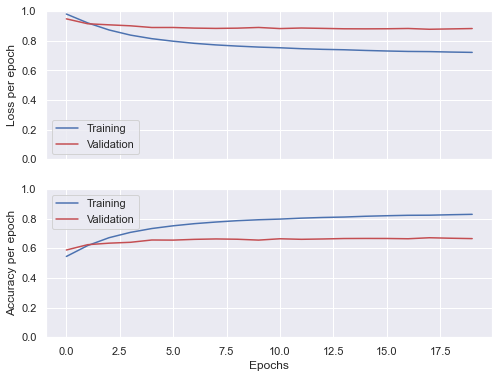

In [293]:
import numpy as np
import matplotlib.pyplot as plt

eps = np.arange(N_EPOCHS)

fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 6), sharex=True)

ax1.set_ylim([0, 1])
ax1.plot(epoch_loss_train,'b')
ax1.plot(epoch_loss_valid,'r')
ax1.set_ylabel("Loss per epoch")
ax1.legend(["Training","Validation"])

ax2.set_ylim([0, 1])
ax2.plot(epoch_accuracy_train,'b')
ax2.plot(epoch_accuracy_valid,'r')
ax2.set_ylabel("Accuracy per epoch")
ax2.set_xlabel("Epochs");
ax2.legend(["Training","Validation"])

plt.show()

In [294]:
def predict(model, sentence):
    tokenised = [token for token in word_tokenize(sentence)]   # Tokenise text 
    indexed = [TEXT.vocab.stoi[token] for token in tokenised]  # Convert tokens to integers
    length = [len(indexed)]                                    # Compute number of words
    tensor = torch.LongTensor(indexed).to(device)              # Convert to PyTorch tensor
    tensor = tensor.unsqueeze(1).T                             # Reshape in form of batch,number of words
    length_tensor = torch.LongTensor(length)                   # Convert to PyTorch tensor
    prediction = model(tensor, length_tensor) 
    prediction=prediction.argmax(dim=1)
# Predict text
    return prediction.item()

label_names = {0:0,1:2,2:4}
lstm_prediction_rtmr=[]
lstm_prediction_s140=[]

for x in rtmr_test_phrases:
    predicted=label_names[predict(model, x)]
    lstm_prediction_rtmr.append(predicted)
    
    
for x in s140_test_tweets:
    predicted=label_names[predict(model, x)]
    lstm_prediction_s140.append(predicted)

print(lstm_prediction_rtmr[0:10])
print(rtmr_test_sen[0:10])
print( )
print(lstm_prediction_s140[0:10])
print(s140_test_sen[0:10])

[2, 2, 4, 0, 0, 0, 0, 2, 2, 0]
[4, 2, 0, 2, 2, 2, 2, 4, 4, 2]

[0, 0, 0, 0, 0, 0, 0, 2, 0, 0]
[4, 4, 4, 4, 4, 4, 0, 4, 4, 4]


Accuracy: 0.209
F1-score: 0.179
Precision: 0.202
Recall: 0.258
              precision    recall  f1-score   support

           0       0.20      0.60      0.30      1706
           2       0.32      0.13      0.18      4027
           4       0.09      0.04      0.06      2070

    accuracy                           0.21      7803
   macro avg       0.20      0.26      0.18      7803
weighted avg       0.23      0.21      0.17      7803



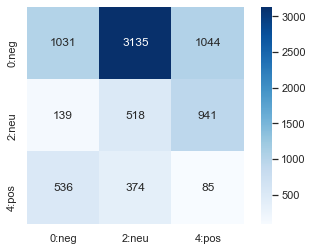

In [295]:
mat = confusion_matrix(rtmr_test_sen, lstm_prediction_rtmr)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",cmap='Blues',xticklabels=['0:neg','2:neu','4:pos'], yticklabels=['0:neg','2:neu','4:pos'])
print('Accuracy: {:.3f}'.format(accuracy_score(rtmr_test_sen, lstm_prediction_rtmr)))
print('F1-score: {:.3f}'.format(f1_score(rtmr_test_sen, lstm_prediction_rtmr, average='macro')))
print('Precision: {:.3f}'.format(precision_score(rtmr_test_sen, lstm_prediction_rtmr, average='macro')))
print('Recall: {:.3f}'.format(recall_score(rtmr_test_sen, lstm_prediction_rtmr, average='macro')))
print(classification_report(rtmr_test_sen, lstm_prediction_rtmr))

Accuracy: 0.351
F1-score: 0.210
Precision: 0.316
Recall: 0.332
              precision    recall  f1-score   support

           0       0.36      0.93      0.51       177
           2       0.29      0.04      0.07       139
           4       0.31      0.02      0.04       182

    accuracy                           0.35       498
   macro avg       0.32      0.33      0.21       498
weighted avg       0.32      0.35      0.22       498



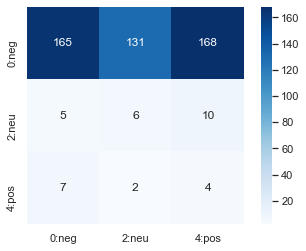

In [296]:
mat = confusion_matrix(s140_test_sen, lstm_prediction_s140)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d",cmap='Blues',xticklabels=['0:neg','2:neu','4:pos'], yticklabels=['0:neg','2:neu','4:pos'])
print('Accuracy: {:.3f}'.format(accuracy_score(s140_test_sen,lstm_prediction_s140)))
print('F1-score: {:.3f}'.format(f1_score(s140_test_sen,lstm_prediction_s140, average='macro')))
print('Precision: {:.3f}'.format(precision_score(s140_test_sen,lstm_prediction_s140, average='macro')))
print('Recall: {:.3f}'.format(recall_score(s140_test_sen,lstm_prediction_s140, average='macro')))
print(classification_report(s140_test_sen,lstm_prediction_s140))